## Time series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin.

⚠️ **Note:** This is not a financial advice.

The predictability of an event or a quantity depends on several factors:
1. how well we understand the factors that contribute to it,
2. how much data is available,
3. how similar the future is to the past,
4. whether the forecasts can affect the thing we are trying to forecast.

## Get Data

The data is from: https://www.coindesk.com/price/bitcoin, and we will be using the closing price of 24 hours.

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2025-02-22 16:02:35--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.004s  

2025-02-22 16:02:38 (43.7 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing time series data with pandas

In [2]:
# Import with pandas
import pandas as pd
# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", parse_dates=["Date"], index_col=["Date"]) # parse the data column and tell pandas that the first column is a date

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292
2021-05-17,BTC,45604.615754,46805.537852,49670.414174,43868.638969
2021-05-18,BTC,43144.471291,46439.336570,46622.853437,42102.346430


In [5]:
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's 2787 samples.

Typically deep learning models like lots and lots of samples (where lots can thousands to tens of thousand to millions).

A smaller number of samples is something we will run into with time series data problems.

> **Note:** The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily value of 365 because we collect one sample per day.

### Types of time series

* **Trend:** time series has a clear long-termn increase or decrease (may or may not be linear).
* **Seasonal:** time series affected by seasonal factors such as time of the year (e.g. increased sales towards end of year).
* **Cyclic:** time series shows rises and falls over an unfixed period, these tend to be longer/more variable than seasonal pattern.

### Univariate and Multivariate time series data

* **Univariate:** Only one variable (using the price of Bitcoin to predict the price of Bitcoin).
* **Multivariate:** More than one variable (using the price of Bitcoin as well as the block reward size to predict the price of Bitcoin).

In [6]:
## Extract only the data we wanted

In [7]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


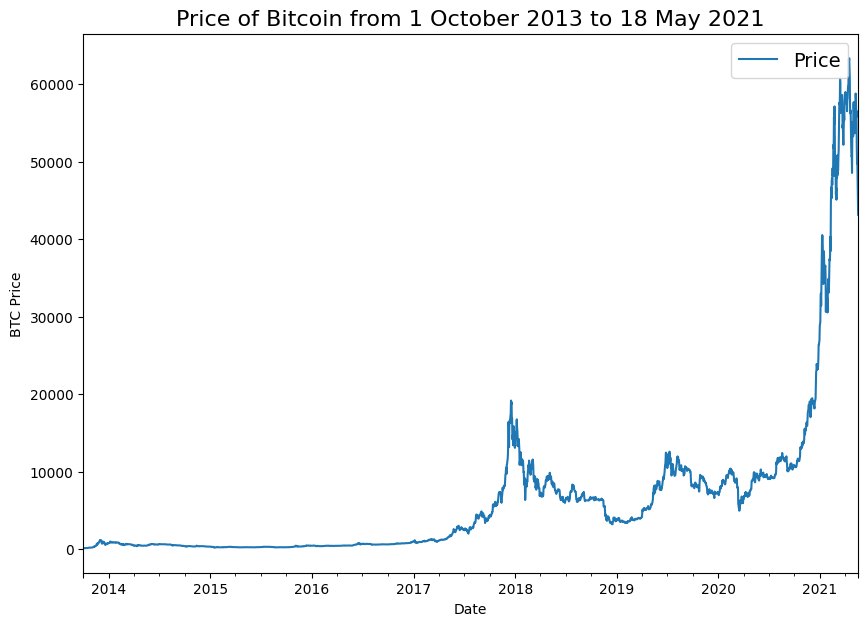

In [8]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 October 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Importing time series data with Python's CSV module

In [9]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (get rid of column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not as strings)
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

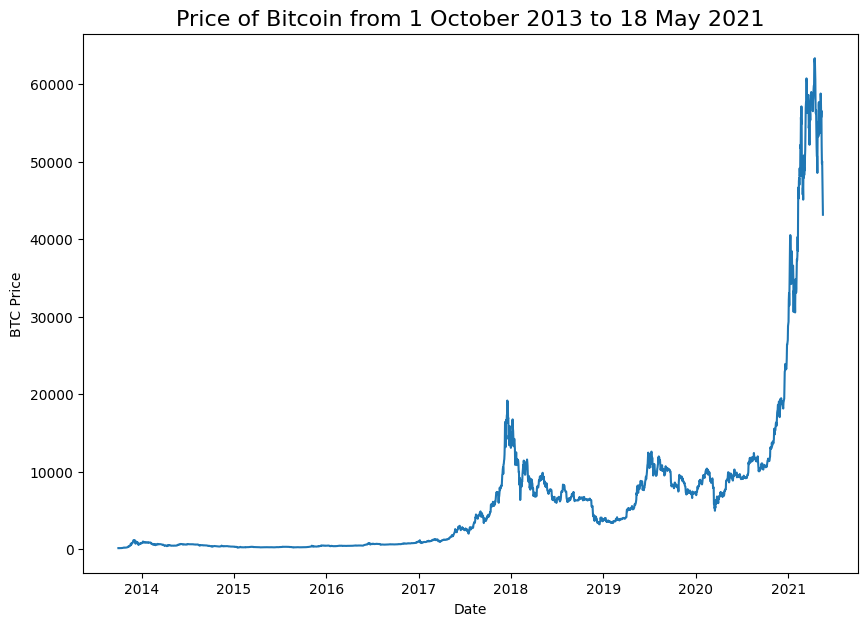

In [10]:
# Plot from csv
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.xlabel("Date")
plt.title("Price of Bitcoin from 1 October 2013 to 18 May 2021", fontsize=16);
#plt.legend() doesn't work for data from python csv

## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (The **WRONG** way)

In [11]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [12]:
# Wrong way to make train/test set for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, prices, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

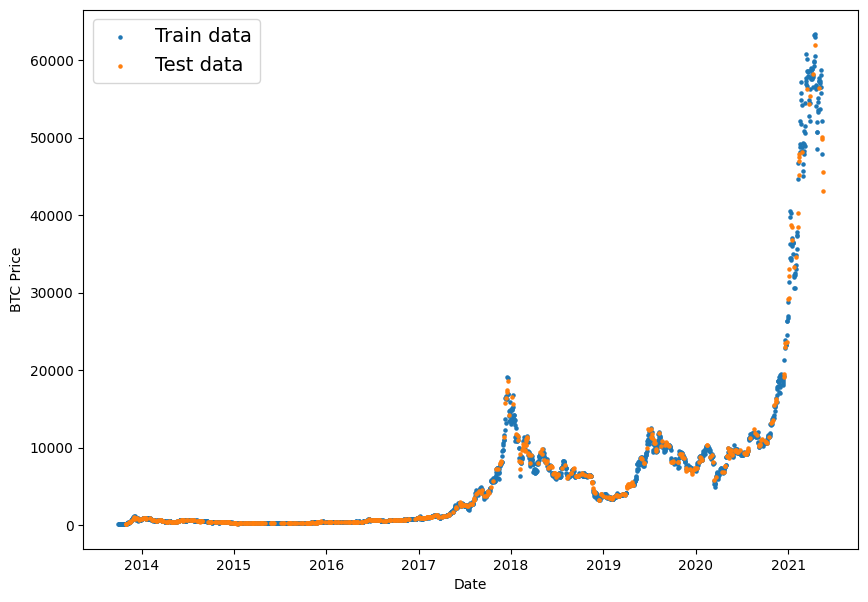

In [13]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

The issue with this is that it is a random split, our training data set is riddled with test data, which is a data leak. Data from the (pseudo) future leaks into past.

### Create train and test sets for time series (the right way)

We use time series split to create train set that represents the past, and test set that represents the (pseudo) future.

In [14]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

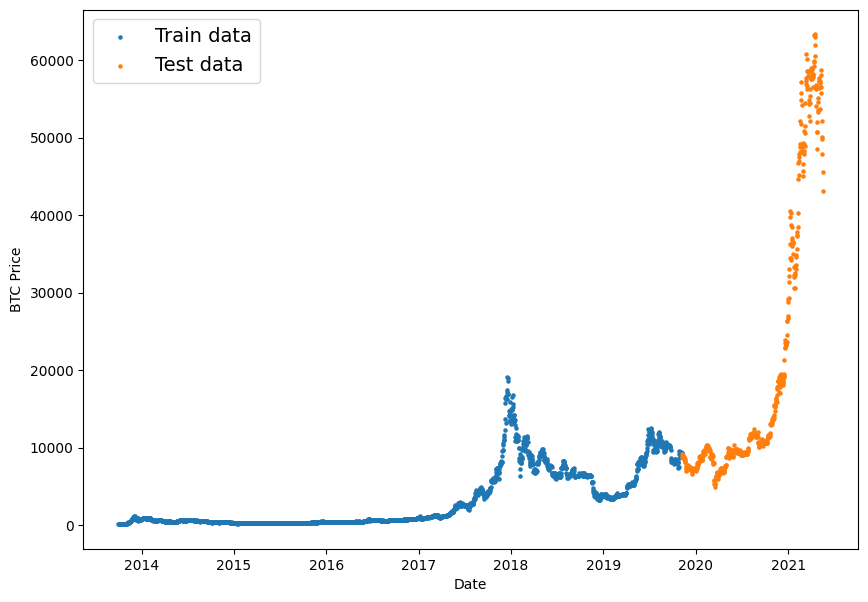

In [15]:
# Plot correctly made splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Create a plotting function

Typing plotting code is tedious, let's functionize it.

In [16]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ----------
  timesteps : array of timestep values
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a values will index from start of timesteps and values)
  end :  where to end the plot (similar to start but for the end)
  label : label to show on plot about values, default None
  """
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

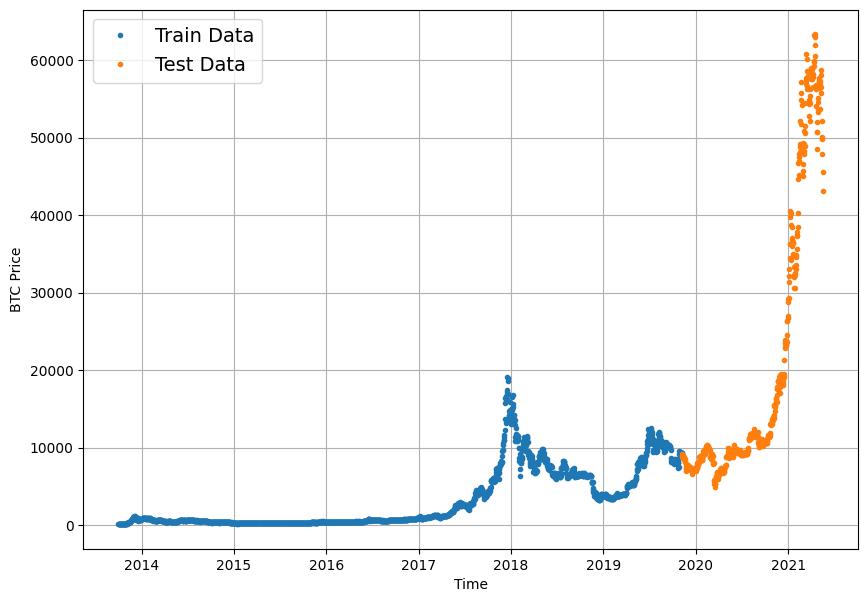

In [17]:
# Testing out plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label="Train Data")
plot_time_series(timesteps=X_test, values=y_test, label="Test Data")

## Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict horizon

The experiments:

0 - Naïve model (baseline)

1 - Dense model (horizon=1, window=7)

2 - Same as model 1 (horizon=1, window=30)

3 - Same as model (horizon=7, window=30)

4 - Conv1D (horizon=1, window=7)

5 - LSTM (RNN) (horizon=1, window=7)

6 - Same as model 1 (but with multivariate data) (horizon=1, window=7)

7 - N-BEATS algorithmn (horizon=1, window=7)

8 - Ensemble (horizon=1, window=7)

9 - Future prediction model (horizon=1, window=7)

10 - Same as model 1 (but with turkey data introduced) (horizon=1, window=7)

## Model 0: Naïve forecast

The formula looks like this:
$$\hat{y}_{t} = y_{t-1}$$

The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

**Ressource:** https://otexts.com/fpp3/simple-methods.html

In [18]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

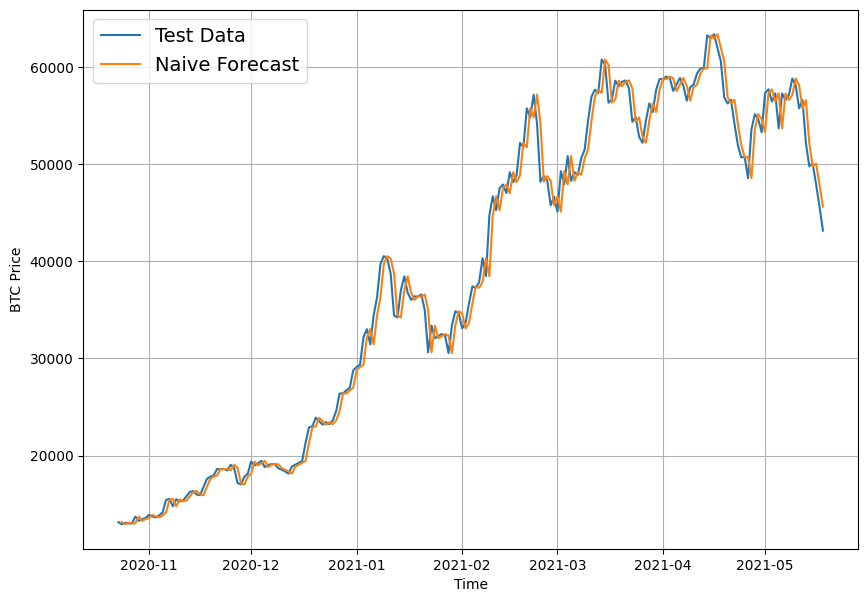

In [19]:
# Plot naive forecast
plt.figure(figsize=(10,7))
#plot_time_series(timesteps=X_train, values=y_train, label="Train Data")
plot_time_series(timesteps=X_test, values=y_test, format="-", start=350, label="Test Data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=350, label="Naive Forecast")

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

We are predicting a number, so that means we have a form of a regression problem and we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean squared error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all the above metrics, lower is better.

The main thing we're evaluating here is: how do our model's forecast (y_pred) compare against the actual values (y_true or ground truth values)?

**Resource:** https://otexts.com/fpp3/accuracy.html

In [20]:
import tensorflow as tf

In [21]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season

In [22]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

In [23]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_pred(y_true, y_pred):
  # Make sure float32 datatype (for metric calculation)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mae(y_true, y_pred)
  mse = tf.keras.metrics.mse(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mape(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [24]:
naive_results = evaluate_pred(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

## Format Data Part 2: Windowing our dataset

We window our time series dataset to turn our data into supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

**Resource (Sliding vs. Expanding Windows):** https://www.uber.com/en-DE/blog/forecasting-introduction/

In [25]:
# What we want to do with our Bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [26]:
# Setup global variables for window and horizon sizes
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make the predictions

In [27]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Create labels for windowed dataset.

  E.g. if horizon = 1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], 7)
  """
  return x[:, :-horizon], x[:, -horizon:]

In [28]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


We need a way to do the above (which is only for small scale data) across our entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage NumPy's array indexing.

Our function will:
1. Create a window step of specific window size.
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps to index on a target series (e.g. the historical price of Bitcoin).
4. Uses the `get_labelled_windows()` function we created above to turn the window steps with specified horizon.

**Resource:** The function we want to create has been adapted from the following article: https://medium.com/towards-data-science/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [29]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled window_size with horizon size labels.
  """
  # 1. Create a window of a specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)
  print(window_step)
  # 2. Create a 2D array of multiple window steps (minum 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T # create 2D array of windows of window_size
  print(window_indexes)
  # 3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]
  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels


In [30]:
full_windows, full_labels = make_windows(prices)

[[0 1 2 3 4 5 6 7]]
[[   0    1    2 ...    5    6    7]
 [   1    2    3 ...    6    7    8]
 [   2    3    4 ...    7    8    9]
 ...
 [2777 2778 2779 ... 2782 2783 2784]
 [2778 2779 2780 ... 2783 2784 2785]
 [2779 2780 2781 ... 2784 2785 2786]]


In [31]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [32]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


> **Note:** We can find a function which achieves similar reasults to the ones we implemented above at `tf.keras.preprocessing.timeseries_dataset_from_array()`. It takes an array and returns a windowed dataset. It has the benefit of returning data in the form of tf.data.Dataset instance. https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array

## Turning windows into training and test sets


In [33]:
# Make the train/test splits
def make_train_test_split(windows, labels, test_split=0.2):
  """
  Split matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train and 20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [34]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [35]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performance against other model's best performance.

For example if our model performs best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

We can create a modelling checkpoint callback using the following: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [36]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name) + ".keras",
                                            verbose=0,
                                            save_best_only=True)

## Model 1: Dense Model (Window = 7, Horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimization and MAE loss function
* Batch size of 128
* 100 epochs

In [37]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name ="model_1_dense")

model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 1835.8187 - mae: 1835.8187 - mse: 9592765.0000 - val_loss: 2907.5745 - val_mae: 2907.5745 - val_mse: 19661410.0000
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 394.2656 - mae: 394.2656 - mse: 535426.7500 - val_loss: 1400.3684 - val_mae: 1400.3684 - val_mse: 5337706.0000
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 217.8841 - mae: 217.8841 - mse: 227040.9375 - val_loss: 1273.0764 - val_mae: 1273.0764 - val_mse: 4561503.0000
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 196.7730 - mae: 196.7730 - mse: 192629.6250 - val_loss: 1097.7994 - val_mae: 1097.7994 - val_mse: 3792640.7500
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 184.1175 - mae: 184.1175 - mse: 174440.1250 - val_loss: 1049.7981 - val_mae: 1049.7981 - val_mse: 3537684.2500
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 177.0140 - mae: 177.0140 - mse: 167266.9375 - val_loss: 1044.1034 - val_mae: 1044.103

In [38]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels) # but it's the model from the last epoch and not the best one

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 285.0518 - mae: 285.0518 - mse: 346819.1875


[572.1049194335938, 572.1049194335938, 1169887.125]

In [39]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense.keras")
model_1.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 285.0518 - mae: 285.0518 - mse: 346819.1875


[572.1049194335938, 572.1049194335938, 1169887.125]

## Making forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only pseudo forecasts because actual forecasts are into the future), let's write a function to:
1. Takes in a trained model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input to the model's `predict()` method
4. Returns the prediction

In [40]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [41]:
# Make predictions
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8831.178, 8782.846, 9061.152, 8757.195, 8733.14 , 8773.906,
        8652.951, 8520.863, 8463.919, 8532.441], dtype=float32)>)

In [42]:
# Evaluate preds
model_1_results = evaluate_pred(y_true=tf.squeeze(test_labels),
                                y_pred=model_1_preds)
model_1_results

{'mae': 572.1049,
 'mse': 1169887.0,
 'rmse': 1081.6132,
 'mape': 2.5581634,
 'mase': 1.0050299}

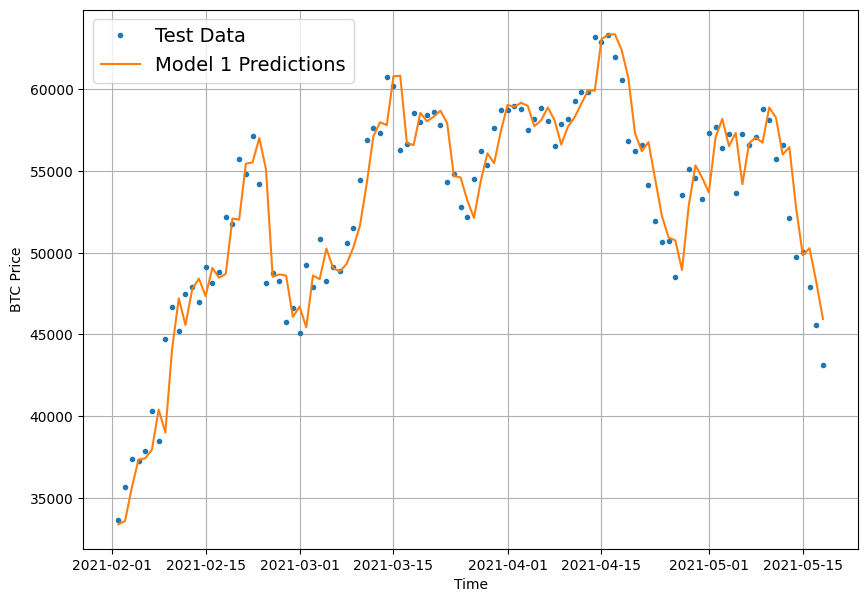

In [43]:
# Plot model_1 predictions
offset = 450
plt.figure(figsize=(10,7))
# Account for the test window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.squeeze(test_labels), start=offset, label="Test Data") # instead of instead we can use test_labels[:,0]
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="Model 1 Predictions")

Why is the model predictions lagged slightly behind the true labels?
-> Autocorrelation: https://otexts.com/fpp3/acf.html

## Model 2: Dense (window = 30, horizon = 1)



In [44]:
HORIZON = 1
WINDOW_SIZE = 30

In [45]:
# Make windowed data with appropriate horizon and window size
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30]]
[[   0    1    2 ...   28   29   30]
 [   1    2    3 ...   29   30   31]
 [   2    3    4 ...   30   31   32]
 ...
 [2754 2755 2756 ... 2782 2783 2784]
 [2755 2756 2757 ... 2783 2784 2785]
 [2756 2757 2758 ... 2784 2785 2786]]


(2757, 2757)

In [46]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [47]:
train_windows[:3], train_labels[:3]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
         160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
         175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 125.96116, 125.27966, 125.9275 , 126.38333, 135.24199,
         133.20333, 142.76333, 137.92333, 142.95166, 152.55183, 160.33883,
         164.31499, 177

In [48]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name = "model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [49]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 370.3592


704.5593872070312

In [50]:
# Load in the best performing model
model_2 = tf.keras.models.load_model("/content/model_experiments/model_2_dense.keras")
model_2.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 315.9336


616.7088012695312

In [51]:
# Get forecast predictions
model_2_preds = make_preds(model_2, input_data=test_windows)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [52]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_pred(y_true=tf.squeeze(test_labels),
                                y_pred=model_2_preds)
model_2_results

{'mae': 616.70886,
 'mse': 1314910.2,
 'rmse': 1146.6953,
 'mape': 2.8198333,
 'mase': 1.0780132}

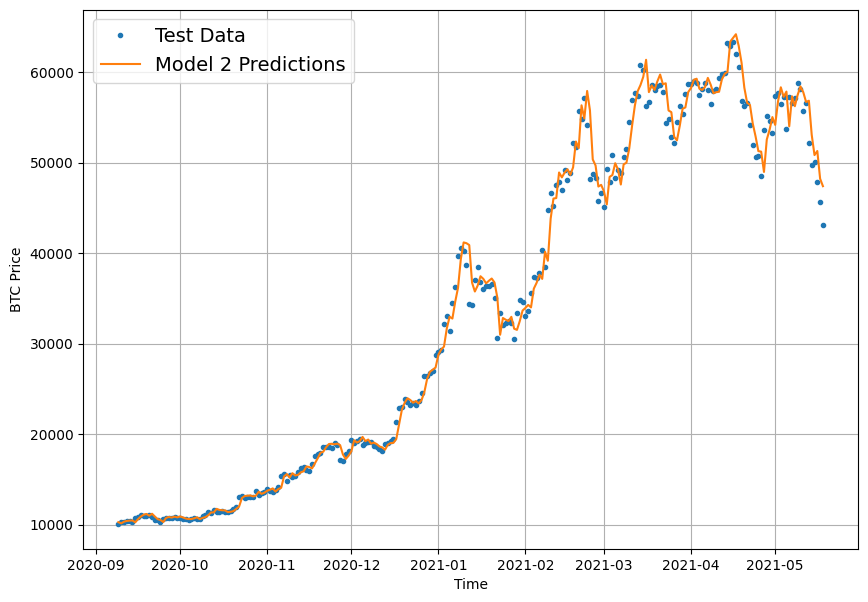

In [53]:
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.squeeze(test_labels), start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="Model 2 Predictions")

## Model 3: Dense (window = 30, horizon = 7)

In [54]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29 30 31 32 33 34 35 36]]
[[   0    1    2 ...   34   35   36]
 [   1    2    3 ...   35   36   37]
 [   2    3    4 ...   36   37   38]
 ...
 [2748 2749 2750 ... 2782 2783 2784]
 [2749 2750 2751 ... 2783 2784 2785]
 [2750 2751 2752 ... 2784 2785 2786]]


(2751, 2751)

In [55]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [56]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(x=train_windows,
            y=train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [57]:
# Evaluate the model on test data
model_3.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 638.7577


1276.6961669921875

In [58]:
# Load in the best performing model
model_3 = tf.keras.models.load_model("/content/model_experiments/model_3_dense.keras")
model_3.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 637.3213


1270.201171875

In [59]:
# Create forecast predictions
model_3_preds = make_preds(model_3, test_windows)
model_3_preds[:5]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9278.234 , 9452.653 , 9466.769 , 9192.136 , 9261.363 , 9338.982 ,
        9272.262 ],
       [8968.585 , 9069.029 , 9333.124 , 9267.665 , 9142.118 , 9052.007 ,
        9028.1875],
       [8882.881 , 8749.155 , 9118.333 , 9200.216 , 8865.633 , 8871.0625,
        8963.748 ],
       [9109.734 , 9038.301 , 9163.143 , 9285.078 , 8944.433 , 9083.566 ,
        9069.113 ],
       [8952.055 , 9005.612 , 9022.331 , 9038.743 , 8783.727 , 8897.762 ,
        8760.271 ]], dtype=float32)>

In [60]:
# Evaluate model_3 results
model_3_results = evaluate_pred(y_true=tf.squeeze(test_labels),
                                y_pred=model_3_preds)
model_3_results # we need to condense these array into single values

{'mae': array([ 529.9849  ,  375.1772  ,  302.5187  ,  472.458   ,  368.5809  ,
         383.6389  ,  435.56543 ,  538.74713 ,  588.2043  ,  625.53754 ,
         708.68756 ,  654.24384 ,  770.36786 ,  792.2694  ,  627.8446  ,
         246.26395 ,  279.05615 ,  307.30414 ,  369.38943 ,  420.8293  ,
         185.55672 ,  100.94698 ,  208.69978 ,  207.58922 ,  204.63832 ,
         177.65535 ,  120.35917 ,   96.90465 ,   68.145645,   71.29659 ,
         224.2959  ,  300.7558  ,  346.05386 ,  286.90387 ,  265.73123 ,
         255.04373 ,  271.8704  ,  237.36844 ,  229.12354 ,  267.75873 ,
         441.604   ,  141.94621 ,  143.68938 ,   81.42041 ,  105.85658 ,
         163.94943 ,  115.59577 ,  129.78271 ,   74.29366 ,   97.42802 ,
         145.65381 ,  154.0752  ,  161.72838 ,  200.62758 ,  324.09332 ,
         368.9705  ,  507.5318  ,  530.9427  ,  585.08307 ,  636.8696  ,
         457.80246 ,  291.9963  ,  327.21658 ,  386.17953 ,  441.2954  ,
         535.08044 ,  481.61908 ,  580.2519 

In [61]:
model_2_preds.shape, model_3_preds.shape, model_2_results["mae"].shape, model_3_results["mae"].shape

(TensorShape([552]), TensorShape([551, 7]), (), (551,))

## Make our evaluation function work for larger horizons

In [62]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_pred(y_true, y_pred):
  # Make sure float32 datatype (for metric calculation)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mae(y_true, y_pred)
  mse = tf.keras.metrics.mse(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mape(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [63]:
# Get model 3 results aggregated to single values
model_3_results = evaluate_pred(y_true=tf.squeeze(test_labels),
                                y_pred=model_3_preds)
model_3_results, naive_results

({'mae': 1270.2012,
  'mse': 5474259.0,
  'rmse': 1462.0162,
  'mape': 5.700006,
  'mase': 2.2602518},
 {'mae': 567.9802,
  'mse': 1147547.0,
  'rmse': 1071.2362,
  'mape': 2.516525,
  'mase': 0.99957})

With model 3, we are trying to predict further into the future. This explains why the model prediction has higher losses.

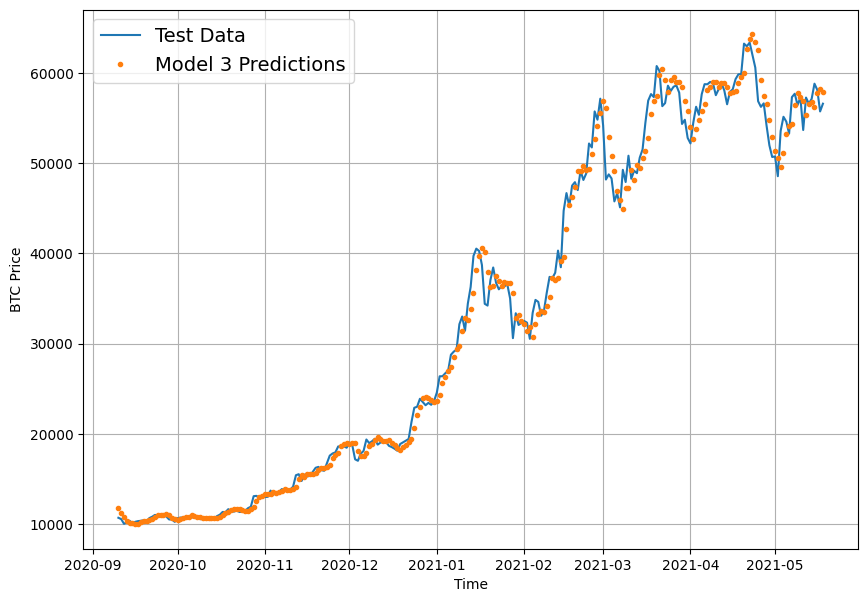

In [64]:
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, format="-", label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), start=offset, label="Model 3 Predictions")

# We actually lost some informations because we reducing the seven days prediction into a single value

## Comparing the models so far

<Axes: >

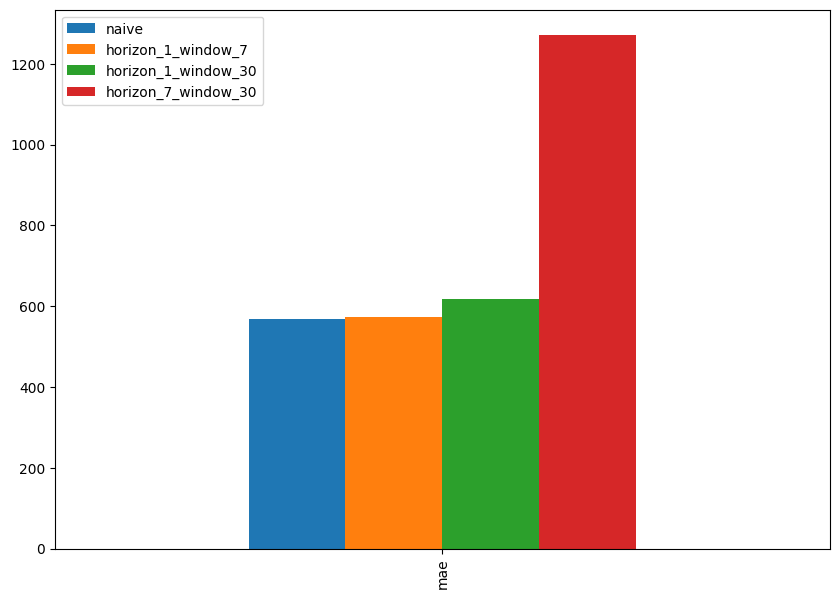

In [65]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10,7), kind="bar")

Why do our naive model did so good in comparison with complexer deep learning model? One of the reason its because the present of autocorrelation in the data. It means the value on this timestep is typically close to the value on the previous timestep. The naive model did good because of high autocorrelation and it is also hinting that our Bitcoin data has high autocorrelation.

**Resource:** https://medium.com/towards-data-science/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424

## Model 4: Conv1D

In [66]:
HORIZON = 1
WINDOW_SIZE = 7

In [67]:
# Create the window dataset (the same with model_1)
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

[[0 1 2 3 4 5 6 7]]
[[   0    1    2 ...    5    6    7]
 [   1    2    3 ...    6    7    8]
 [   2    3    4 ...    7    8    9]
 ...
 [2777 2778 2779 ... 2782 2783 2784]
 [2778 2779 2780 ... 2783 2784 2785]
 [2779 2780 2781 ... 2784 2785 2786]]


(2780, 2780)

In [68]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(train_labels)

(2224, 2224, 556, 2224)

To use the Conv1D layer, we need an input shape of: `(batch_size, timesteps, input_dim)`.

**Resource:** https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D

In [70]:
# Before our pass our data to the Conv1D layer, we have to reshape it
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [74]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension

In [75]:
# Test out our lambda layer
print(f"Original shape: {x.shape}") # WINDOW_SIZE
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [82]:
def expand_dims(x):
  return tf.expand_dims(x, axis=1)

In [84]:
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    # layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # must create a separate function instead of a lambda function in order to reload the model safely
    layers.Lambda(expand_dims),
    layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
    layers.Dense(HORIZON)
], name="model_4_conv1d")

model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [85]:
model_4.summary()

Model: "model_4_conv1d"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_3 (Lambda)                    │ (None, 1, 7)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 1, 128)              │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1, 1)                │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,213 (55.52 KB)

 Trainable params: 4,737 (18.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,476 (37.02 KB)

In [86]:
# Evaluate model
model_4.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 289.6855


575.6329345703125

In [88]:
# Load in best performing model and re-evaluate
model_4 = tf.keras.models.load_model("/content/model_experiments/model_4_conv1d.keras", custom_objects={'expand_dims': expand_dims})
model_4.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 283.5649


568.69775390625

In [89]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8875.042, 8780.176, 9013.156, 8793.932, 8721.809, 8727.054,
       8686.512, 8519.095, 8455.387, 8519.561], dtype=float32)>

In [91]:
# Evaluate predictions
model_4_results = evaluate_pred(y_true=tf.squeeze(test_labels),
                                y_pred=model_4_preds)
model_4_results

{'mae': 568.69775,
 'mse': 1175347.1,
 'rmse': 1084.1343,
 'mape': 2.5383487,
 'mase': 0.9990444}

## Model 5: RNN (LSTM)

In [97]:
tf.random.set_seed(42)

# Let's build the LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE,))
x = layers.Lambda(expand_dims)(inputs)
#x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
#x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - loss: 3078.1467 - val_loss: 12979.5918
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1647.1189 - val_loss: 2598.6169
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 287.0524 - val_loss: 1055.4557
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 191.5979 - val_loss: 1038.1284
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 183.0589 - val_loss: 1098.1360
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 180.3539 - val_loss: 1077.5422
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 178.6247 - val_loss: 1056.8188
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 177.0773 - val_loss: 1079.5363
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 177.8395 - val_loss: 1075.4153
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 174.8639 - val_loss: 1041.0284
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 172.2402 - val_loss: 1030.5898
Epo

In [99]:
# Load in best performing model and evaluate
model_5 = tf.keras.models.load_model("/content/model_experiments/model_5_lstm.keras", custom_objects={'expand_dims': expand_dims})
model_5.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 296.0478


590.2781982421875

In [100]:
# Make predictions
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8933.999, 8811.629, 8947.219, 8787.777, 8751.586, 8708.025,
       8683.454, 8558.365, 8450.887, 8502.629], dtype=float32)>

In [101]:
# Evaluate predictions
model_5_results = evaluate_pred(y_true=tf.squeeze(test_labels),
                                y_pred=model_5_preds)
model_5_results

{'mae': 590.2782,
 'mse': 1242635.0,
 'rmse': 1114.7354,
 'mape': 2.662223,
 'mase': 1.0369554}

In [102]:
model_1_results

{'mae': 572.1049,
 'mse': 1169887.0,
 'rmse': 1081.6132,
 'mape': 2.5581634,
 'mase': 1.0050299}